In this project, datetime and matplotlib are being used to plot the number of Donald's tweets versus the a.) date, b.) day of the week and c.) time of the day. Also, his most used words have been analyzed. 

1.First, to get his tweets, a loop has been created to hit the twitter API multiple times (since he's got a lot of tweets and Twitter has a limit to the amount of tweets that I can request at once.) This next code gets all of these tweets and save them to a file called new_tweets.json:

In [49]:
import twurl2
import json
import hidden

outfile = open('new_tweets.json', 'w')
wrap_list=[] #since I need to make a twitter API call repeatedly I will wrap the JSON info into a list

TWITTER_URL = 'https://api.twitter.com/1.1/statuses/user_timeline.json'
acct = 'realdonaldtrump'
twittercount=200 #pull 200 tweets at a time (the max)
secrets = hidden.oauth()
full_url=''.join([TWITTER_URL,'?','count=',str(twittercount),'&', 'screen_name=', acct])
user_timeline = twurl2.oauth_req( full_url, secrets['token_key'], secrets['token_secret'], "GET" )
js=json.loads(user_timeline)
wrap_list.append(js)

#twitter gives an ID with each tweet...keep hitting the twitter API until you run out of new IDs
old_max_id=0
max_id=js[len(js) - 1]['id']

while old_max_id!=max_id:
    old_max_id=max_id
    full_url=''.join([TWITTER_URL,'?','count=',str(twittercount),'&', 'screen_name=', acct, '&', 'max_id=', str(max_id)])
    user_timeline = twurl2.oauth_req( full_url, secrets['token_key'], secrets['token_secret'], "GET" )
    js = json.loads(user_timeline)

    max_id=js[len(js) - 1]['id']
    wrap_list.append(js)

json.dump(wrap_list, outfile)
outfile.close()

print('newest_tweet', wrap_list[0][0]['text'],wrap_list[0][0]['created_at'])
print('')
print('oldest_tweet', wrap_list[-1][0]['text'],wrap_list[-1][0]['created_at'])

newest_tweet The Fake Mainstream Media has, from the time I announced I was running for President, run the most highly sophistic… https://t.co/sLngXtjuiV Tue May 29 13:30:24 +0000 2018

oldest_tweet HAPPY PRESIDENTS DAY - MAKE AMERICA GREAT AGAIN! Mon Feb 20 14:33:33 +0000 2017


2.Merge with older lists to get a complete data set.

In [50]:
import json

js=[]

#load older tweets
with open('old_tweets.json') as json_data1:
    js1 = json.load(json_data1)

#load newer tweets
with open('new_tweets.json') as json_data2:
    js2 = json.load(json_data2)

#merge both tweets
for j in range(len(js1)):
    js.append(js1[j])

for j in range(len(js2)):
    for i in range(len(js2[j])):
        js.append(js2[j][i])

#delete duplicates based on creation time
datelist=[]
count=0
dups_removed=[]

for j in range(len(js)):
    date=js[j]['created_at']
    if date not in datelist: #remove duplicates
        datelist.append(date)
        count = count + 1
        dups_removed.append(js[j])

#update donalddata.json to include all non-duplicate tweets
outfile = open('donalddata.json', 'w')
json.dump(dups_removed, outfile)
outfile.close()

print('number of unique tweets', count)

number of unique tweets 6323


3.Load the donalddata.json data that has just being created back in in json format.

In [51]:
# insert 3
with open('donalddata.json') as donalddata:
    data = json.load(donalddata)
    print(data[1])

{'created_at': 'Thu Mar 23 01:03:18 +0000 2017', 'id': 844716149828993025, 'id_str': '844716149828993025', 'text': 'RT @mitchellvii: EXACTLY AS I SAID - House Intel Chair: We Cannot Rule Out Sr. Obama Officials Were Involved in Trump Surveillance https://…', 'truncated': False, 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'mitchellvii', 'name': 'Bill Mitchell', 'id': 17980523, 'id_str': '17980523', 'indices': [3, 15]}], 'urls': []}, 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 25073877, 'id_str': '25073877', 'name': 'Donald J. Trump', 'screen_name': 'realDonaldTrump', 'location': 'Washington, DC', 'description': '45th President of the United States of America', 'url': None, 'entities': {'description': {'urls': []}}, 'protected': F

4.Create three lists for the tweet texts, created_at, and number_of_retweets data. Then store them in a single pandas dataframe called df.

In [52]:
#insert 4
import pandas as pd
text = []
created_at = []
retweet_count = []

for i in range(len(data)):
    text.append(data[i]['text'])
    created_at.append(data[i]['created_at'])
    retweet_count.append(data[i]['retweet_count'])

df = pd.DataFrame({'text':text, 'created_at':created_at,'retweet_count':retweet_count})
df.head()

,created_at,retweet_count,text
0,Thu Mar 23 01:04:32 +0000 2017,2896,RT @mitchellvii: Trump always ends up being ri...
1,Thu Mar 23 01:03:18 +0000 2017,1625,RT @mitchellvii: EXACTLY AS I SAID - House Int...
2,Wed Mar 22 13:09:35 +0000 2017,10233,Big day for healthcare. Working hard!
3,Tue Mar 21 18:12:05 +0000 2017,13207,"Today on #NationalAgDay, we honor our great Am..."
4,Tue Mar 21 17:33:23 +0000 2017,13448,Honored to sign S.442 today. With this legisla...


5.Which did the tweet that had the most retweets say? 

In [53]:
#insert 5
df.loc[df['retweet_count'].idxmax()]['text']

'#FraudNewsCNN #FNN https://t.co/WYUnHjjUjg'

6.Convert the Twitter data (in UTC time) to Eastern Time Zone time. Create a new column called eastern_time_zone:

In [54]:
import datetime
import pytz
from dateutil.parser import parse

tz = pytz.timezone('US/Eastern')

time_zone = []
for j in range(len(data)):
    time_zone.append(parse(data[j]['created_at']).astimezone(tz))
    
df['eastern_time_zone'] = time_zone

df.head()

,created_at,retweet_count,text,eastern_time_zone
0,Thu Mar 23 01:04:32 +0000 2017,2896,RT @mitchellvii: Trump always ends up being ri...,2017-03-22 21:04:32-04:00
1,Thu Mar 23 01:03:18 +0000 2017,1625,RT @mitchellvii: EXACTLY AS I SAID - House Int...,2017-03-22 21:03:18-04:00
2,Wed Mar 22 13:09:35 +0000 2017,10233,Big day for healthcare. Working hard!,2017-03-22 09:09:35-04:00
3,Tue Mar 21 18:12:05 +0000 2017,13207,"Today on #NationalAgDay, we honor our great Am...",2017-03-21 14:12:05-04:00
4,Tue Mar 21 17:33:23 +0000 2017,13448,Honored to sign S.442 today. With this legisla...,2017-03-21 13:33:23-04:00


7.Create a new column that includes just the hour of each tweets (use pandas built in datetime capabilities to do this in one line). Then plot a histogram of the date versus the number of tweets on that date. 

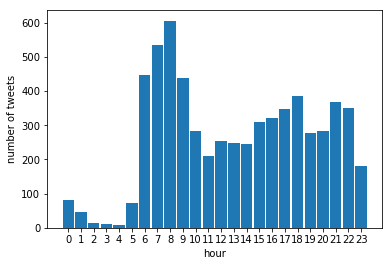

In [55]:
#insert 7
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df['hour'] = df['eastern_time_zone'].dt.hour
df.hour.plot.hist(rwidth=.9, bins=np.arange(-.5,24.5,1))
plt.xlabel('hour')
plt.ylabel('number of tweets')
plt.xticks(np.arange(0,24,1))
plt.show()

8.From the graph above, which hour does he tweet at most often?

In [56]:
#insert 8
#hour 8

9.How many tweets has he sent between midnight and 4:00 am in this dataset?

In [57]:
#insert 9
df[(df['hour'] >= 0) & (df['hour'] <= 4)].count()

created_at           158
retweet_count        158
text                 158
eastern_time_zone    158
hour                 158
dtype: int64

10.Make a histogram of day of week vs number of tweets using pandas built in datetime capabilities. Recall that Monday corresponds to 0. 

Change the x-axis labels so that you see "Mon, Tues, etc." instead of "0,1,2...."

Make sure the bins and the labels are centered nicely.

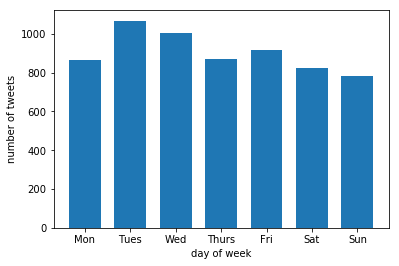

In [58]:
#insert 10
df['day of week'] = df['eastern_time_zone'].dt.weekday
df['day of week'].plot.hist(rwidth=.7, bins=np.arange(-.5,7.5,1))
plt.xlabel('day of week')
plt.ylabel('number of tweets')
x = df['day of week']
plt.xticks(np.arange(7), ('Mon', 'Tues', 'Wed', 'Thurs', 'Fri','Sat','Sun'))
plt.show()

11.Next, make a bar chart for date versus number of tweets. This will take a couple of steps. First, create a dictionary called count_days such that the key is the date (just the month-day-year - not the hour or other stuff - you can do this easily) and the value is the number of tweets on that date. 

In [59]:
#insert 11
from collections import Counter
df['date'] = df['eastern_time_zone'].dt.date
count_days = Counter(df['date'])

12.Next, plot this dictionary using a histogram.

<Container object of 785 artists>

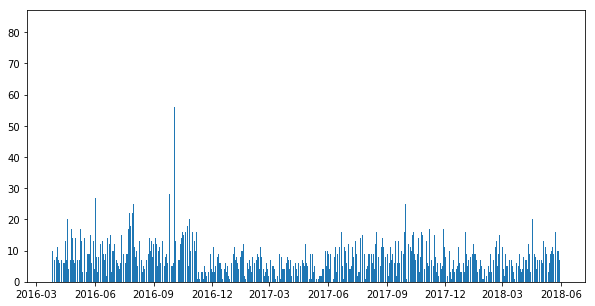

In [60]:
#insert 12
import pylab as pl
import numpy as np

plt.rcParams['figure.figsize'] = [10, 5]
plt.bar(list(count_days.keys()),count_days.values())
#X = np.arange(len(count_days))
#pl.bar(list(count_days.keys()), count_days.values(), align='center', width=0.5)
#pl.xticks(list(count_days.keys()), count_days.keys())
#ymax = max(count_days.values()) + 1
#pl.ylim(0, ymax)
#pl.show()

13.On which date did he tweet the most?

In [61]:
#insert 13
count_days.most_common()[0][0]

datetime.date(2016, 10, 19)

14.What were the texts of those tweets on that date?

In [62]:
#insert 14
df[(df['date'] == datetime.date(2016, 10, 19))].text

943     That was really exciting. Made all of my point...
944     Join my team over on my Facebook page- live no...
945     The era of division is coming to an end. We wi...
946     We cannot take four more years of Barack Obama...
947     I started this campaign to Make America Great ...
948     HILLARY'S HEALTH CARE POLICIES\n#DrainTheSwamp...
949     RT @TeamTrump: .@realDonaldTrump is going to c...
950     We have to repeal &amp; replace #Obamacare! Lo...
951     ISIS has infiltrated countries all over Europe...
952     The economy cannot take four more years of the...
953     Together we can save American JOBS, American L...
954     USA has the greatest business people in the wo...
955     I WILL DEFEAT ISIS. THEY HAVE BEEN AROUND TOO ...
956     RT @TeamTrump: What They Are Saying About @rea...
957     After Crooked @HillaryClinton allowed ISIS to ...
958     RT @TeamTrump: "Her instincts are suboptimal."...
959     I opposed going into Iraq. Hillary voted for i...
960     #BigLe

15.Now we'll explore Trump's most frequently used words. To do this, create a loop that iterates through each tweet text and saves them all to one long string called "all_tweets".

In [63]:
#insert 15
all_tweets = ''
for i in df.text:
    all_tweets += i

16.Make the entire string lower case (since we want Hillary and hillary to be equivalent) and resave it as "cleaned_tweets".

In [64]:
#insert 16
cleaned_tweets = all_tweets.lower()

17.Also, we'll want to strip all of the punctuation.

In [65]:
import string
cleaned_tweets = cleaned_tweets.translate(str.maketrans('','',string.punctuation))
cleaned_tweets[0:100]

'rt mitchellvii trump always ends up being right  its almost a little freakyrt mitchellvii exactly as'

18.Create a dictionary called counts whose key is each word and whose value is the number of times that that word occurs.

In [66]:
#insert 18
counts = Counter(cleaned_tweets.split())
print(counts)

Counter({'the': 4381, 'to': 2921, 'and': 2305, 'of': 2039, 'in': 1807, 'a': 1644, 'is': 1518, 'for': 1234, 'on': 1091, 'will': 1066, 'you': 979, 'great': 877, 'be': 869, 'with': 808, 'i': 796, 'are': 777, 'that': 765, 'our': 739, 'amp': 690, 'we': 683, 'at': 654, 'have': 579, 'was': 517, 'it': 516, 'all': 438, 'by': 430, 'my': 411, 'not': 405, 'has': 399, 'this': 396, 'hillary': 385, 'people': 376, 'me': 370, 'they': 364, 'trump': 359, 'very': 352, 'so': 337, 'from': 330, 'us': 325, 'who': 324, 'realdonaldtrump': 314, 'america': 305, 'as': 300, 'just': 296, 'he': 295, 'clinton': 282, 'president': 276, 'out': 272, 'about': 264, 'now': 264, 'new': 256, 'news': 251, 'no': 244, 'thank': 241, 'today': 228, 'big': 225, 'more': 224, 'get': 218, 'country': 218, 'but': 218, 'their': 217, 'make': 217, 'many': 215, 'an': 203, 'media': 203, 'she': 203, 'up': 201, 'am': 198, 'fake': 196, 'been': 196, 'would': 194, 'time': 193, 'jobs': 188, 'going': 184, 'crooked': 184, 'do': 181, 'or': 181, 'americ

19.Create a sorted list of tuples called tuple_list in reverse order of his most frequently used words. Only print the words that occur at least ten times.

In [67]:
#insert 19
tuple_list = list(reversed(counts.most_common()))
for a, b in tuple_list:
    if b>=10:
        print(a)

delegation
an…
and…
emmanuelmacron
accomplished
amazon
in…
meddling
aluminum
missile
connecticut
rick
mcconnell
side
local
pleased
native
hate
benefits
reports
judgejeanine
lots
plane
showing
debatenight
positive
staff
agents
defend
syrian
probably
obamas
name
acting
release
25
wsj
bobby
tpp
decisions
ny
arabia
joined
answer
cincinnati
sell
maga…
rapids
grand
brought
fl
additional
financial
attacks
raised
disrespect
cover
amounts
info
fools
kellyannepolls
communities
nominee
bigger
turning
understand
line
push
weeks
divided
it’s
rules
challenge
packed
gets
onesided
remembrance
primaries
candidates
themselves
notice
charges
especially
bob
800
super
apologize
anymore
attorney
promise
enough
situation
death
dr
spend
500
debt
leaks
orlando
access
ran
industry
reporter
moving
rep
powerful
hurricaneharvey
corker
i…
korean
remarks…
lady
america’s
nyprimary
rebuild
june
pittsburgh
opportunity
matter
greta
strength
pensacola
netanyahu
m
wednesday
relief
vpdebate
path
msm
turn
majority
joe
hoax


20.One last thing...word cloud visualizations are kind of a hot thing right now. Let's make one, but get rid of the boring words like "the" that aren't very interesting. Recreate the count dictionary in number 18 above but add keys that are not in the boring list below:

boring_words=['at', 'be','was', 'by', 'our','do','so','amp','by','it','its','at','by' 'from', 'as', 'but','am','of', 'a', 'you', 'on', 'the', 'is', 'to', 'and', 'in', 'has', 'are', 'not', 'an', 'in', 'or', 'for', 'who', 'that', 'have', 'there', 'just', 'their', 'were', 'what' , 'with', 'will', 'than', 'about', 'this','if','from','would','been','had']



In [68]:
#insert 20
boring_words=['at', 'be','was', 'by', 'our','do','so','amp','by','it','its','from', 'as', 'but','am','of', 'a', 'you', 'on', 'the', 'is', 'to', 'and', 'in', 'has', 'are', 'not', 'an', 'in', 'or', 'for', 'who', 'that', 'have', 'there', 'just', 'their', 'were', 'what' , 'with', 'will', 'than', 'about', 'this','if','from','would','been','had']
boring_words=set(boring_words)
for i in boring_words:
    try:
        counts.pop(i)
    except:
        continue
print(counts)

Counter({'great': 877, 'i': 796, 'we': 683, 'all': 438, 'my': 411, 'hillary': 385, 'people': 376, 'me': 370, 'they': 364, 'trump': 359, 'very': 352, 'us': 325, 'realdonaldtrump': 314, 'america': 305, 'he': 295, 'clinton': 282, 'president': 276, 'out': 272, 'now': 264, 'new': 256, 'news': 251, 'no': 244, 'thank': 241, 'today': 228, 'big': 225, 'more': 224, 'get': 218, 'country': 218, 'make': 217, 'many': 215, 'media': 203, 'she': 203, 'up': 201, 'fake': 196, 'time': 193, 'jobs': 188, 'going': 184, 'crooked': 184, 'american': 180, 'your': 180, 'tax': 175, 'her': 173, 'never': 169, 'much': 168, 'back': 168, 'his': 166, 'should': 165, 'vote': 161, 'again': 153, 'want': 153, 'bad': 152, 'trump2016': 152, 'day': 150, 'can': 150, 'one': 150, 'democrats': 142, 'years': 140, 'must': 138, 'when': 138, 'good': 136, 'like': 136, 'obama': 134, 'honor': 134, 'last': 133, 'said': 131, 'first': 130, 'united': 123, 'being': 120, 'election': 120, 'makeamericagreatagain': 120, 'only': 119, 'state': 118, 

21.We'll save the words and their frequencies to a javascript file that we can view on a webpage. Here's the code.


In [69]:
# ##########################################
#plot counts using d3, to view the visualization open the twitterword.htm file in a web browser
# ##########################################
x = sorted(counts, key=counts.get, reverse=True)
highest = None
lowest = None
for k in x[:100]:
    if highest is None or highest < counts[k] :
        highest = counts[k]
    if lowest is None or lowest > counts[k] :
        lowest = counts[k]

# Spread the font sizes across 20-100 based on the count
bigsize = 80
smallsize = 20

fhand = open('donaldwords.js','w')
fhand.write("donaldwords = [")
first = True
for k in x[:100]:
    if not first : fhand.write( ",\n")
    first = False
    size = counts[k]
    size = (size - lowest) / float(highest - lowest)
    size = int((size * bigsize) + smallsize)
    fhand.write("{text: '"+k+"', size: "+str(size)+"}")
fhand.write( "\n];\n")

print ("Output written to donaldwords.js")


Output written to donaldwords.js


22.Now open the twitterword.html file in a web browser to view the word cloud. Take a screenshot of it and save it as twitter.jpg. Then run the code to see the screenshot below.

double click into this cell and then run it
<img src="twitter.jpg" style="width: 200px;"/>

23.The word cloud was created using the D3 JavaScript library for visualizing data. It is super hot right now! You could pretty much get hired right now if you are good with it. Check out some other visualizations you can do with it here:

https://github.com/d3/d3/wiki/Gallery


### Chatbot
24.Now let's make a Donald Trump chatbot that uses his previous tweets to create new tweets. We'll go back to the string all_tweets that contains all of his tweets before punctuation is removed.

First, we'll remove certain punctuation (and hashtags and hyperlinks) and put spaces between other punctuation. We can do that most easily using regular expressions. The regular expression package is very powerful - there are loads of online tutorials for using regular expressions to manipulate strings. I highly recommend reading about them. But in the meantime, you can just read my code carefully below and run the code:

In [70]:
import re

all_tweets = re.sub(r"http\S+", "", all_tweets) #remove hyperlinks
all_tweets = re.sub(r"amp\S+", "", all_tweets) #remove ampersand symbol
all_tweets = re.sub(r"\t", "", all_tweets)  # remove tabs
all_tweets = re.sub(r"\v", "", all_tweets)  # remove vertical space
all_tweets = re.sub(r"\r", "", all_tweets)  # remove carriage return
all_tweets = re.sub(r"\n", "", all_tweets)  # remove new lines
all_tweets = re.sub(r"\(", "", all_tweets)  # remove parenthesis
all_tweets = re.sub(r"\)", "", all_tweets)  # remove parenthesis
all_tweets = re.sub(r"\.\.\.", "", all_tweets)  # remove ...
all_tweets = re.sub(r"\. \. \. ", "", all_tweets)  # remove . . .
all_tweets = re.sub(r"\"", "", all_tweets)  # remove quotations
all_tweets = re.sub(r"!", "! ", all_tweets)  # insert space after !
all_tweets = re.sub(r"\.", ". ", all_tweets)  # insert space after .
all_tweets = re.sub(r"\?", "? ", all_tweets)  # insert space after ?
all_tweets = all_tweets.lower()

25.Split the string all_tweets into a list of words called words. Remove words that contain just punctuation in the following list:

bad_words=['…', '.', '!', '?', ',']

In [71]:
#insert 25
words = all_tweets.split()
bad_words=['…', '.', '!', '?', ',']
for i in words:
    if i in bad_words:
        words.remove(i)
print(words)

['rt', '@mitchellvii:', 'trump', 'always', 'ends', 'up', 'being', 'right.', "it's", 'almost', 'a', 'little', 'freaky.', 'rt', '@mitchellvii:', 'exactly', 'as', 'i', 'said', '-', 'house', 'intel', 'chair:', 'we', 'cannot', 'rule', 'out', 'sr.', 'obama', 'officials', 'were', 'involved', 'in', 'trump', 'surveillance', 'day', 'for', 'healthcare.', 'working', 'hard!', 'today', 'on', '#nationalagday,', 'we', 'honor', 'our', 'great', 'american', 'farmers', '&', 'ranchers.', 'their', 'hard', 'work', '&', 'dedication', 'are', 'ingrained…', 'to', 'sign', 's.', '442', 'today.', 'with', 'this', 'legislation,', 'we', 'support', "@nasa's", 'scientists,', 'engineers,', 'and', 'astronauts', 'in', 'the…', 'the', '@housegop', 'conference', 'this', 'morning', 'at', 'the', 'u.', 's.', 'capitol.', '#passthebill', '#maga🇺🇸…', 'you', 'louisville,', 'kentucky.', 'together,', 'we', 'will', 'make', 'america', 'safe', 'and', 'great', 'again!', 'you', 'louisville,', 'kentucky-', 'on', 'my', 'way!', '#maga🇺🇸', 'er

26.Okay, now gets to the fun part where we actually get to make a chatbot. We'll do this using Markov chains. A Markov chain is a randomly determined model describing a sequence of possible events in which the probability of each event depends only on the state attained in the previous event. What does this mean?

We'll make a key-value dictionary where each key is a two word phrase and each value is a list containing all the possible single words that come after that phrase. Here's a concrete example. Read it carefully, paying special attention to the "and i" phrase.

"hi my name is Al and i live in a box that i like very much and i can live in there as long as i want"

"hi my" -> ["name"]

"my name" -> ["is"]

"name is" -> ["Al"]

"is Al" -> ["and"]

"Al and" -> ["i"]

"and i" -> ["live"]

........

"and i" -> ["live", "can"]

........

"i can" -> ["live"]

......

Make a dictionary that does this type of Markov chain for all_tweets called word_dict below. Here are a few helpful hints:

You can't iterate ALL the way until the end of the list (or else you'll go out of index). You may need to stop a few words short.

For each new two word phrase, store the first word value to a LIST. Then, if that two word phrase comes around again, you can append the next possible word to that list.

In [72]:
#insert 26
word_dict = {}
for i in range(len(words)-2):
    key = words[i]+' '+words[i+1]
    val = words[i+2]
    if key in word_dict and val not in word_dict[key]:
        word_dict[key].append(val)
    else:
        word_dict[key]=[val]
print(word_dict)

{'rt @mitchellvii:': ['trump', 'exactly'], '@mitchellvii: trump': ['always'], 'trump always': ['ends'], 'always ends': ['up'], 'ends up': ['being', 'badly'], 'up being': ['right.'], 'being right.': ["it's"], "right. it's": ['almost'], "it's almost": ['a'], 'almost a': ['little'], 'a little': ['freaky.', 'later', 'while.', 'boy,', 'bit'], 'little freaky.': ['rt'], 'freaky. rt': ['@mitchellvii:'], '@mitchellvii: exactly': ['as'], 'exactly as': ['i'], 'as i': ['have'], 'i said': ['no', 'there'], 'said -': ['house'], '- house': ['intel'], 'house intel': ['chair:'], 'intel chair:': ['we'], 'chair: we': ['cannot'], 'we cannot': ['allow', 'have', 'do.', 'keep', 'be', 'safely'], 'cannot rule': ['out'], 'rule out': ['sr.', 'a'], 'out sr.': ['obama'], 'sr. obama': ['officials'], 'obama officials': ['were'], 'officials were': ['involved'], 'were involved': ['in'], 'involved in': ['the'], 'in trump': ['tower', 'camp'], 'trump surveillance': ['day'], 'surveillance day': ['for'], 'day for': ['the', 

27.Now randomly choose a key (two word phrase) to start with and then take that key and print a random value of that key (single word that follows). To do this, go back to Unit 4 to remember how to use random.choice and random.randint.

Create a string called new_tweet that contains the random initial starting phrase (called starting_phrase) and the following word, with a space in between.

Capitalize the starting word (hint: use .capitalize())

In [73]:
#insert 27
import random
starting_phrase = random.choice(list(word_dict))
word = random.choice(word_dict[starting_phrase])
new_tweet = str(starting_phrase+' '+word).capitalize()
print(new_tweet)

Being charged. please


28.Update the starting_phrase to now be the last two words of the string, with a space in between.

In [74]:
#insert 28
starting_phrase = new_tweet.split()[-2]+' '+new_tweet.split()[-1]
print(starting_phrase)

charged. please


29.While the new tweet is less than 140 characters, create a loop that continues to add new words to the new_tweet string by generating a new random number and a new word that follows the last starting_phrase. Each time through the loop, update the starting phrase.

Note: You will need to use a try/except because not all pairs of words that you put together are in the word_dict. If you get to a pair that isn't in the word dict, proceed as follows:


a.If the pair ends in a period, simply end the sentence.

b. If the pair does not end in a period, generate a new random starting phrase and continue creating a new sentence.

In [77]:
#insert 29
starting_phrase = random.choice(list(word_dict))
word = random.choice(word_dict[starting_phrase])
new_tweet = str(starting_phrase+' '+word).capitalize()

while len(new_tweet)<140:
    starting_phrase = new_tweet.split()[-2]+' '+new_tweet.split()[-1]
    try:
        word = random.choice(word_dict[starting_phrase])
    except:
        starting_phrase = random.choice(list(word_dict))
        word = random.choice(word_dict[starting_phrase])
    new_tweet += ' '+word
    if new_tweet[-1] == '.':
        break
print(new_tweet)

Knowledge, is the genesis of this presidency aren't reported about.


30.Run the last several lines of code several times. Copy and paste the new_tweet that sounds most realistic below.

In [28]:
#insert 30
#Knowledge, is the genesis of this presidency aren't reported about.